In [292]:
import numpy as np
import PIL
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [293]:
withMask = []
withoutMask = []

In [294]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [295]:
import glob 
import shutil

def createMaskList():
  tmp_list = []
  pattern = "/content/drive/MyDrive/AFDB_masked_face_dataset/*/*"  
  for img in glob.glob(pattern):
      tmp_list.append(str(img))
  return tmp_list

withMask = createMaskList();

In [296]:
print(len(withMask))
print(withMask[0])

2203
/content/drive/MyDrive/AFDB_masked_face_dataset/zuojinzhu/0_0_006vBMIgjw1fabb8ghpxrj30im0cgjt5.jpg


In [297]:
import glob 
import shutil

def createNoMaskList():
  count = 0
  tmp_list = []   
  pattern = "/content/drive/MyDrive/AFDB_face_dataset/*/*"  
  for img in glob.glob(pattern):
    if (count == 4500):
        break
    tmp_list.append(str(img))
    count += 1
  return tmp_list

withoutMask = createNoMaskList();

In [298]:
print(len(withoutMask))

4500


In [299]:
def createDatabase(mask, no_mask):
  dataBase = []
  label = []
  for path in mask:
    img = cv2.imread(path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray_img,(64, 64), interpolation=cv2.INTER_CUBIC)
    dataBase.append(resized.flatten())
    label.append(1)
    
  
  for path in no_mask:
    img = cv2.imread(path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray_img,(64, 64), interpolation=cv2.INTER_CUBIC)
    dataBase.append(resized.flatten())
    label.append(0)
  
  return dataBase, label

mask_dataset, mask_label = createDatabase(withMask, withoutMask)

In [300]:
print(len(mask_dataset))
print(len(mask_dataset[0]))
print(len(mask_label))

6703
4096
6703


##Scaling

In [301]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

scaler.fit(mask_dataset)  
mask_dataset_Std = scaler.transform(mask_dataset) 

##PCA

In [302]:
from sklearn.decomposition import PCA
pca = PCA(0.99)
mask_dataset_pca = pca.fit_transform(mask_dataset_Std)

In [303]:
pca.explained_variance_ratio_

array([2.82866069e-01, 1.26133040e-01, 6.89639395e-02, 6.49422409e-02,
       3.88417349e-02, 3.28806241e-02, 3.08467886e-02, 1.77662985e-02,
       1.59637562e-02, 1.57326906e-02, 1.16109300e-02, 1.10597532e-02,
       1.00538418e-02, 9.06556320e-03, 8.48579798e-03, 7.69677908e-03,
       6.95342744e-03, 6.50291124e-03, 5.87632089e-03, 5.56664029e-03,
       5.35858624e-03, 5.25228123e-03, 4.84802410e-03, 4.71381750e-03,
       4.28848081e-03, 4.12206749e-03, 3.88424197e-03, 3.87137988e-03,
       3.65606297e-03, 3.42115832e-03, 3.06236608e-03, 3.04512059e-03,
       2.97738661e-03, 2.88027764e-03, 2.71687193e-03, 2.60954266e-03,
       2.43492802e-03, 2.36481624e-03, 2.31800947e-03, 2.18228654e-03,
       2.16570993e-03, 2.12055036e-03, 2.06248613e-03, 1.99077777e-03,
       1.95795190e-03, 1.92712236e-03, 1.86033225e-03, 1.81247163e-03,
       1.75183595e-03, 1.65236087e-03, 1.59924048e-03, 1.57632055e-03,
       1.51563686e-03, 1.48496291e-03, 1.47040519e-03, 1.41285125e-03,
      

In [304]:
pca.n_components_

800

##LDA

In [305]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
mask_dataset_lda = lda.fit_transform(mask_dataset_Std, mask_label)

In [306]:
lda.explained_variance_ratio_

array([1.])

##Shuffling

In [307]:
from sklearn.utils import shuffle

def Shuffle(array1, array2):
  array1_shuffled, array2_shuffled = shuffle(array1, array2)
  return array1_shuffled, array2_shuffled

##Train-Test-Split

In [308]:
from sklearn.model_selection import train_test_split

In [309]:
mask_dataset_shuffle, y = Shuffle(mask_dataset, mask_label)  

X_train, X_test, y_train, y_test = train_test_split(mask_dataset_shuffle, y, test_size=0.1)

In [310]:
mask_dataset_shuffle_pca, y_pca = Shuffle(mask_dataset_pca, mask_label)  

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(mask_dataset_shuffle_pca, y_pca, test_size=0.1)

In [311]:
mask_dataset_shuffle_lda, y_lda = Shuffle(mask_dataset_lda, mask_label)  

X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(mask_dataset_shuffle_lda, y_lda, test_size=0.1)

##Training

In [312]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

##SVC

In [313]:
from sklearn.svm import SVC
def trainSVC(train_data, label_data, test_data,test_label):
  model = SVC()
  
  model.fit(train_data,label_data)
  print(model.score(test_data,test_label))
  cvs = cross_val_score(model, train_data, label_data, cv=5)
  print(cvs)
  predicted_test = model.predict(test_data)
  return predicted_test, cvs

##SVC_Normal

In [314]:
predicted_SVC, cvs_SVC = trainSVC(X_train, y_train, X_test,  y_test)
predicted_SVC

0.9433681073025335
[0.95111848 0.93951947 0.94361526 0.93117745 0.9344942 ]


array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,

In [315]:
accuracy_score(y_test, predicted_SVC)

0.9433681073025335

In [316]:
f1_score(y_test, predicted_SVC)

0.9054726368159204

In [317]:
log_loss(y_test, predicted_SVC)

1.9560093868529635

##SVC_PCA

In [318]:
predicted_SVC_pca, cvs_SVC_pca = trainSVC(X_train_pca, y_train_pca, X_test_pca, y_test_pca)
predicted_SVC_pca

0.9329359165424739
[0.93869097 0.94366197 0.94029851 0.94195688 0.95439469]


array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,

In [319]:
accuracy_score(y_test_pca, predicted_SVC_pca)

0.9329359165424739

In [320]:
f1_score(y_test_pca, predicted_SVC_pca)

0.8946135831381733

In [321]:
log_loss(y_test_pca, predicted_SVC_pca)

2.3163292574253864

##SVC_LDA

In [322]:
predicted_SVC_lda, cvs_SVC_lda = trainSVC(X_train_lda, y_train_lda, X_test_lda, y_test_lda)
predicted_SVC_lda

0.9791356184798807
[0.98011599 0.98922949 0.99087894 0.98507463 0.9800995 ]


array([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [323]:
accuracy_score(y_test_lda, predicted_SVC_lda)

0.9791356184798807

In [324]:
f1_score(y_test_lda, predicted_SVC_lda)

0.9674418604651163

In [325]:
log_loss(y_test_lda, predicted_SVC_lda)

0.7206313995919231

##Comparison

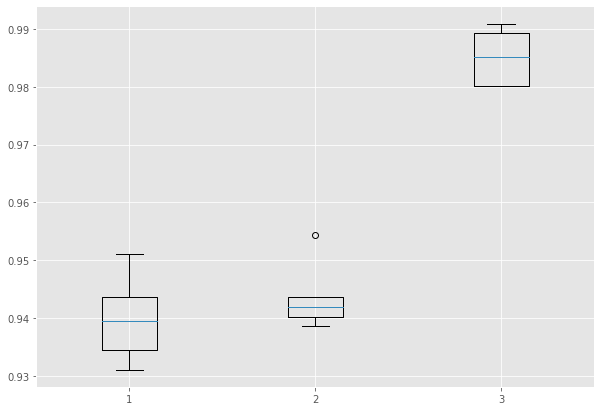

In [326]:
#BoxPlot for cross validation scores

data_SVC = [cvs_SVC, cvs_SVC_pca,cvs_SVC_lda]

fig_SVC = plt.figure(figsize =(10, 7))
  
# Creating plot
plt.boxplot(data_SVC)
  
# show plot
plt.show()

##MLP

In [327]:
from sklearn.neural_network import MLPClassifier
def trainMLP(train_data, label_data, test_data,test_label):
  clf = MLPClassifier()
  clf=clf.fit(train_data,label_data)
  print(clf.score(test_data,test_label))
  cvs = cross_val_score(clf, train_data, label_data, cv=5)
  print(cvs)
  predicted_test = clf.predict(test_data)
  return predicted_test, cvs

##MLP_Normal

In [328]:
predicted_MLP, cvs_MLP = trainMLP(X_train, y_train, X_test,  y_test)
predicted_MLP

0.6885245901639344
[0.66942833 0.91797846 0.57379768 0.91708126 0.85074627]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [329]:
accuracy_score(y_test, predicted_MLP)

0.6885245901639344

In [330]:
f1_score(y_test, predicted_MLP)

0.0

In [331]:
log_loss(y_test, predicted_MLP)

10.757979532841032

##MLP_PCA

In [332]:
predicted_MLP_pca, cvs_MLP_pca = trainMLP(X_train_pca, y_train_pca, X_test_pca, y_test_pca)
predicted_MLP_pca

0.9210134128166915
[0.91549296 0.92792046 0.90630182 0.9344942  0.92703151]


array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,

In [333]:
accuracy_score(y_test_pca, predicted_MLP_pca)

0.9210134128166915

In [334]:
f1_score(y_test_pca, predicted_MLP_pca)

0.8781609195402299

In [335]:
log_loss(y_test_pca, predicted_MLP_pca)

2.728127480881015

##MLP_LDA

In [336]:
predicted_MLP_lda, cvs_MLP_lda = trainMLP(X_train_lda, y_train_lda, X_test_lda, y_test_lda)
predicted_MLP_lda

0.9806259314456036
[0.97845899 0.98840099 0.99087894 0.98590381 0.97844113]


array([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [337]:
accuracy_score(y_test_lda, predicted_MLP_lda)

0.9806259314456036

In [338]:
f1_score(y_test_lda, predicted_MLP_lda)

0.9698375870069605

In [339]:
log_loss(y_test_lda, predicted_MLP_lda)

0.669157813310387

##Comaprison

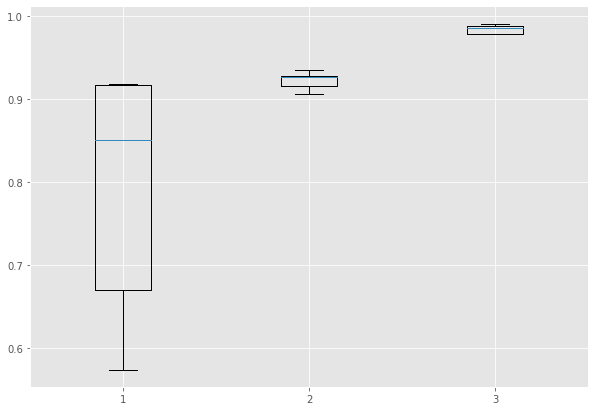

In [340]:
#BoxPlot for cross validation scores

data_MLP = [cvs_MLP, cvs_MLP_pca,cvs_MLP_lda]

fig_MLP = plt.figure(figsize =(10, 7))
  
# Creating plot
plt.boxplot(data_MLP)
  
# show plot
plt.show()

##Random Forest

In [341]:
from sklearn.ensemble import RandomForestClassifier
def trainRandomForest(train_data, label_data, test_data,test_label):
  clf = RandomForestClassifier()
  clf=clf.fit(train_data,label_data)
  print(clf.score(test_data,test_label))
  cvs = cross_val_score(clf, train_data, label_data, cv=5)
  print(cvs)
  predicted_test = clf.predict(test_data)
  return predicted_test, cvs


##RandomForest_Normal

In [342]:
predicted_RF, cvs_RF = trainRandomForest(X_train, y_train, X_test,  y_test)
predicted_RF

0.9225037257824144
[0.93123447 0.92626346 0.92620232 0.91956882 0.90298507]


array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,

In [343]:
accuracy_score(y_test, predicted_RF)

0.9225037257824144

In [344]:
f1_score(y_test, predicted_RF)

0.8673469387755102

In [345]:
log_loss(y_test, predicted_RF)

2.676641978095303

##RandomForest_PCA

In [346]:
predicted_RF_pca, cvs_RF_pca = trainRandomForest(X_train_pca, y_train_pca, X_test_pca, y_test_pca)
predicted_RF_pca

0.8703427719821163
[0.85335543 0.85998343 0.86650083 0.86318408 0.86318408]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,

In [347]:
accuracy_score(y_test_pca, predicted_RF_pca)

0.8703427719821163

In [348]:
f1_score(y_test_pca, predicted_RF_pca)

0.7862407862407862

In [349]:
log_loss(y_test_pca, predicted_RF_pca)

4.478232989404493

##RandomForest_LDA

In [350]:
predicted_RF_lda, cvs_RF_lda = trainRandomForest(X_train_lda, y_train_lda, X_test_lda, y_test_lda)
predicted_RF_lda

0.9791356184798807
[0.97514499 0.98425849 0.98092869 0.97595357 0.97097844]


array([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [351]:
accuracy_score(y_test_lda, predicted_RF_lda)

0.9791356184798807

In [352]:
f1_score(y_test_lda, predicted_RF_lda)

0.9677419354838709

In [353]:
log_loss(y_test_lda, predicted_RF_lda)

0.7206337828927583

##Comparison

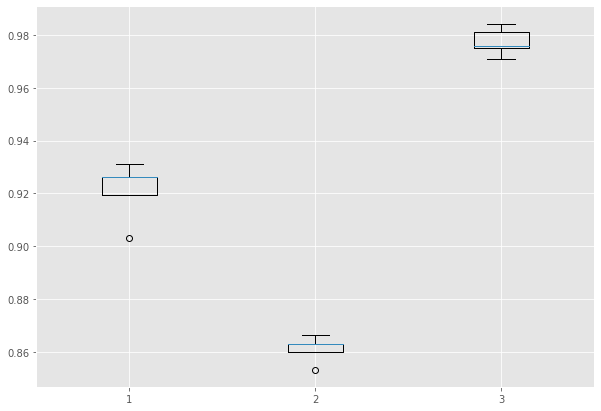

In [354]:
#BoxPlot for cross validation scores

data_RF = [cvs_RF, cvs_RF_pca,cvs_RF_lda]

fig_RF = plt.figure(figsize =(10, 7))
  
# Creating plot
plt.boxplot(data_RF)
  
# show plot
plt.show()

##CNN

In [384]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [385]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [386]:
def createDatabaseCNN(mask, no_mask):
  dataBase = []
  label = []
  for path in mask:
    img = cv2.imread(path)
   
    resized = cv2.resize(img,(64, 64), interpolation=cv2.INTER_CUBIC)
    
    dataBase.append(resized)
    label.append(1)
    
  
  for path in no_mask:
    img = cv2.imread(path)
    resized = cv2.resize(img,(64, 64), interpolation=cv2.INTER_CUBIC)
    dataBase.append(resized)
    label.append(0)
  
  return dataBase, label

mask_dataset_cnn, mask_label_cnn = createDatabaseCNN(withMask, withoutMask)

In [387]:
print(mask_dataset_cnn)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [388]:
mask_dataset_cnn= np.array(mask_dataset_cnn, dtype="float32")
mask_label_cnn = np.array(mask_label_cnn)

In [389]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
mask_label_cnn = lb.fit_transform(mask_label_cnn)
mask_label_cnn = to_categorical(mask_label_cnn)

In [390]:
(trainX, testX, trainY, testY) = train_test_split(mask_dataset_cnn, mask_label_cnn,
	test_size=0.20, stratify=mask_label_cnn, random_state=42)

In [391]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [392]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(64, 64,3)))

In [393]:
first_cnn_model = baseModel.output
first_cnn_model = AveragePooling2D(pool_size=(2, 2))(first_cnn_model)
first_cnn_model = Flatten(name="flatten")(first_cnn_model)
first_cnn_model = Dense(128, activation="relu")(first_cnn_model)
first_cnn_model = Dropout(0.5)(first_cnn_model)
first_cnn_model = Dense(2, activation="softmax")(first_cnn_model)

In [394]:
model = Model(inputs=baseModel.input, outputs=first_cnn_model)

In [395]:
for layer in baseModel.layers:
	layer.trainable = False

In [396]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [397]:
CNN = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
167/167 [==============================] - 9s 37ms/step - loss: 0.7177 - accuracy: 0.6617 - val_loss: 0.4448 - val_accuracy: 0.8031
Epoch 2/20
167/167 [==============================] - 6s 35ms/step - loss: 0.4918 - accuracy: 0.7782 - val_loss: 0.4237 - val_accuracy: 0.8113
Epoch 3/20
167/167 [==============================] - 6s 35ms/step - loss: 0.4490 - accuracy: 0.8003 - val_loss: 0.3845 - val_accuracy: 0.8479
Epoch 4/20
167/167 [==============================] - 6s 35ms/step - loss: 0.4191 - accuracy: 0.8254 - val_loss: 0.3692 - val_accuracy: 0.8441
Epoch 5/20
167/167 [==============================] - 6s 37ms/step - loss: 0.4109 - accuracy: 0.8244 - val_loss: 0.3576 - val_accuracy: 0.8516
Epoch 6/20
167/167 [==============================] - 6s 37ms/step - loss: 0.3944 - accuracy: 0.8337 - val_loss: 0.3507 - val_accuracy: 0.8538
Epoch 7/20
167/167 [==============================] - 6s 36ms/step - loss: 0.3884 - accuracy: 0.8409 - val_loss: 0.3497 - val_accuracy: 0.8516

In [398]:
predIdxs = model.predict(testX, batch_size=BS)

In [399]:
predIdxs = np.argmax(predIdxs, axis=1)

In [400]:
test_Y = np.argmax(testY, axis=1)

In [401]:
print(accuracy_score(test_Y,predIdxs))

0.8732289336316182


In [402]:
test_Y_ = np.argmax(test_Y, axis=0)

In [403]:
print(classification_report(test_Y, predIdxs))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       900
           1       0.82      0.78      0.80       441

    accuracy                           0.87      1341
   macro avg       0.86      0.85      0.85      1341
weighted avg       0.87      0.87      0.87      1341



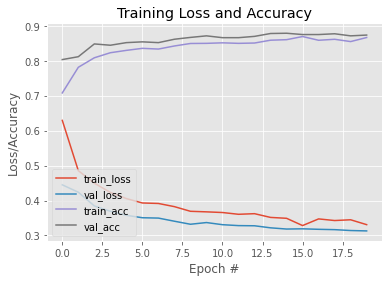

In [404]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), CNN.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), CNN.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), CNN.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), CNN.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
